In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [3]:
if not GEMINI_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

In [95]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

In [ ]:
## Gemini
# chat_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
chat_llm = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

In [97]:
## Groq

chat_llm = ChatGroq(model="openai/gpt-oss-120b")

In [98]:
chat_llm.invoke("Hello, How are you?").content

"Hello! I'm doing great, thanks for asking. How can I assist you today?"

In [99]:
from typing_extensions import TypedDict, Annotated
import operator

In [100]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [101]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
# u can add many number of messages in a list. For Eg: ["Hi", "How are you?"]

In [102]:
{
    "messages": [HumanMessage(content="Hi, This is Sharan. Say hello in a detail.")]
}

{'messages': [HumanMessage(content='Hi, This is Sharan. Say hello in a detail.', additional_kwargs={}, response_metadata={})]}

In [103]:
def llm_call(state:GraphState) -> dict:
    """Call the llm using conversation messages and append AI response"""
    response = chat_llm.invoke(state["messages"])
    return {"messages": [response]}

In [104]:
def token_counter(state:GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    text = last_msg.content
    token_number = len(text.split())
    Summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {"messages": [AIMessage(content=Summary)]}

In [105]:
from langgraph.graph import StateGraph

In [106]:
builder = StateGraph(GraphState)

In [107]:
builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [108]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [109]:
app = builder.compile()

In [110]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

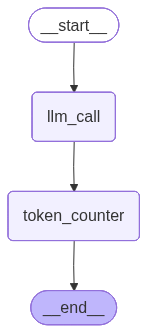

In [111]:
from IPython.core.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [113]:
# Call this above graph flow
result = app.invoke({"messages": [HumanMessage(content="Hi, This is Sharan. Say hello in a detail.")]})

In [114]:
result

{'messages': [HumanMessage(content='Hi, This is Sharan. Say hello in a detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello, Sharan! 👋\n\nIt’s wonderful to meet you. I hope you’re having a great day so far. Whether you’re sipping a cup of coffee, tackling a project, or just taking a moment to relax, I’m here and ready to chat. If there’s anything specific you’d like to discuss—questions, ideas, or just a friendly conversation—feel free to let me know. Looking forward to hearing more about what’s on your mind!', additional_kwargs={'reasoning_content': 'The user says: "Hi, This is Sharan. Say hello in a detail." They want a detailed greeting. There\'s no disallowed content. So respond with a detailed hello, perhaps personalized. Use friendly tone.'}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 84, 'total_tokens': 233, 'completion_time': 0.317401412, 'completion_tokens_details': {'reasoning_tokens': 45}, 'prompt_time': 0.00314

In [115]:
for i in result["messages"]:
    print(type(i).__name__, ":", i.content)

HumanMessage : Hi, This is Sharan. Say hello in a detail.
AIMessage : Hello, Sharan! 👋

It’s wonderful to meet you. I hope you’re having a great day so far. Whether you’re sipping a cup of coffee, tackling a project, or just taking a moment to relax, I’m here and ready to chat. If there’s anything specific you’d like to discuss—questions, ideas, or just a friendly conversation—feel free to let me know. Looking forward to hearing more about what’s on your mind!
AIMessage : Total token number in the generated answer (word count) is 69


In [116]:
chat_llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000018496F44F80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018496F8DF40>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

### WikiPedia Tool

In [117]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [118]:
api_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=500)

In [119]:
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [120]:
wiki_tool.run({"query": "what is Generative AI?"})

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

## TOOLS

##### What is Tool?: Its any service or application that can be used to perform a specific task.

##### What is Agent? : It is a program that can use tools to perform a specific task.

##### Agentic Flow = LLM + Tool Calling + Memory + Planning


### 1. Tavily Tool

In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [143]:
if not TAVILY_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [144]:
TAVILY_API_KEY

'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'

In [145]:
tavily_tool = TavilySearchResults(TAVILY_API_KEY=TAVILY_API_KEY)

In [146]:
tavily_tool.invoke({"query": "How is the job market for software engineers in 2026?"})

[{'title': 'Software Engineering Job Market Outlook for 2026 - Final Round AI',
  'url': 'https://www.finalroundai.com/blog/software-engineering-job-market-2026',
  'content': "The key insight isn’t just that hiring slowed. This convergence means competition has intensified across the board. Entry-level candidates can’t rely on volume hiring anymore, and experienced engineers can’t assume their resumes will float to the top automatically.\n\nFor the 2026 software engineering job market, this matters a lot. It signals a shift from growth-at-all-costs hiring to precision hiring. Teams are smaller, and expectations are higher.\n\n## Top Programming Languages for 2026\n\nHere's what employers are actually looking for when they hire in 2026: [...] While we believe that the job market in 2026 will be in the low-hiring, low-firing phase, does the same apply to developer jobs? The reality is way more complicated, which we will try to understand in our outlook for the Software Engineering Job M

### 2. DuckDuckGo Search Tool

In [131]:
from langchain_community.tools import DuckDuckGoSearchResults
duckgo_search = DuckDuckGoSearchResults()

In [132]:
duckgo_search.invoke("What is the news for iphone 17 release date?")

"snippet: 9 Sept 2025 · Pre-orders begin Friday, September 12, with availability beginning Friday, September 19. “iPhone 17 Pro is by far the most powerful iPhone we've ever made, with ..., title: Apple unveils iPhone 17 Pro and iPhone 17 Pro Max, the most powerful and advanced Pro models ever, link: https://www.apple.com/newsroom/2025/09/apple-unveils-iphone-17-pro-and-iphone-17-pro-max/, snippet: 3 days ago · The iPhone 17e Release Date has been LEAKED! Today we are going over the latest Apple news, Leaks and the iPhone 17 Rumors. Get the COOLEST look on your ..., title: iPhone 17e Release Date LEAK! - NEW $499 Price? - YouTube, link: https://www.youtube.com/watch?v=ssrXwCzIFTs, snippet: 26 Aug 2025 · Apple just announced their September iPhone event which will take place on September 9th at 10:00 am PT, and there is a lot they are going to announce at ..., title: Apple September Event - iPhone 17 Price, Release Date & Huge Surprises! - YouTube, link: https://www.youtube.com/watch?v=

### 3. Serper Tool

In [ ]:
import os
import pprint
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

In [134]:
if not SERPER_API_KEY:
    raise ValueError ("API_KEY is missing your .env file")
os.environ["TAVILY_API_KEY"] = SERPER_API_KEY

In [135]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper_tool = GoogleSerperAPIWrapper()

In [136]:
serper_tool.run("Who is Narendra Modi?")

"Narendra Damodardas Modi (born 17 September 1950) is an Indian politician who has served as the prime minister of India since 2014. Modi was the chief minister ... Narendra Modi (born September 17, 1950, Vadnagar, India) is an Indian politician and government official who rose to become a senior leader of the Bharatiya ... Mr. Modi is the third child born to Damodardas Modi and Hiraba Modi. Mr. Modi comes from a family of humble origins and modest means. Experience · Prime Minister of India. Government of India. May 2014 - Present 11 years 10 months · Chief Minister of Gujarat. Government of Gujarat. Oct 2001 - ... The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019. Narendra Modi. 54112476 likes · 4449826 talking about this. Prime Minister of India. 2001, Chief Minister of Gujarat; served four terms. Since May 2014, Prime Minister of India, becoming the first ever PM to be born after India attai

### 4. Youtube Search Tool

In [147]:
from langchain_community.tools import YouTubeSearchTool

In [148]:
youtube_search_tool = YouTubeSearchTool()

In [149]:
youtube_search_tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [150]:
youtube_search_tool.run("Sharan,5")

"['https://www.youtube.com/watch?v=j-TOQyqbwRA&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=7oDshjZzW98&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=SEWKNflu4qA&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=pN-oI_-lR6M&pp=ygUGU2hhcmFu', 'https://www.youtube.com/watch?v=E-TFgPHwqEk&pp=ygUGU2hhcmFu0gcJCYcKAYcqIYzv']"

#### 5. Custom Tool Creation - Tool Decorators

In [151]:
def multiply(a:int, b:int)->int:
    return a*b

In [152]:
multiply(2,5) # its a just function call

10

##### Converting Custom Tool def function to Tool generator

In [153]:
from langchain.tools import tool

In [154]:
@tool
def multiply(a:int, b:int) -> int:
    """This tool Multiplies two numbers"""
    return a*b

In [155]:
multiply.invoke({"a": 2, "b": 3})

6

In [156]:
multiply.name

'multiply'

In [157]:
multiply.description

'This tool Multiplies two numbers'

In [158]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [159]:
@tool
def add(a:int, b:int) -> int:
    """This tool Add two numbers"""
    return a+b

In [160]:
add.invoke({"a": 2, "b": 3})

5

In [161]:
add.name

'add'

In [162]:
add.description

'This tool Add two numbers'

In [163]:
add.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [164]:
@tool
def get_word_length(word:str) -> int:
    """It is a tool to count the length of the word"""
    return len(word)

In [165]:
get_word_length.invoke("Hello How are you") # Either this or the next line

17

In [166]:
get_word_length.invoke({"word":"Hello How are you"})

17

In [167]:
@tool
def call_gmail_api(args):
    """This is a tool to call Gmail API"""
    pass

In [168]:
@tool
def call_sqlite_db(args):
    """This is a tool to call Sqllite DB"""
    pass

### 6. To Excess Real time data

In [169]:
import yfinance as yf

In [170]:
@tool
def get_stock_price(ticker: str) -> str:
    """This is a tool to get stock price using Yfinance"""
    try:
        stock = yf.Ticker(ticker)

        # Get last 1 day historical data
        data = stock.history(period="1d")

        if data.empty:
            return f"No data found for {ticker}. Please check the symbol"
        latest_close = data['Close'].iloc[-1]

        # Detect Currency
        currency = stock.info.get("currency", "")
        symbol_map = {
            "INR": "₹",
            "USD": "$",
            "EUR": "€",
            "GBP": "£",
            "JPY": "¥"
        }
        symbol = symbol_map.get(currency, "")
        currency_text = currency if currency else ""

        if symbol:
            return f"The last closing price of {ticker.upper()} was {symbol}{latest_close:.2f}."
        else:
            return f"The last closing price of {ticker.upper()} was {latest_close:.2f} {currency_text}."

    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [171]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $417.44.'

In [172]:
get_stock_price.invoke("TCS.NS")

'The last closing price of TCS.NS was ₹2683.60.'

In [173]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $255.78.'

In [174]:
get_stock_price.invoke("HDFCBANK.NS")

'The last closing price of HDFCBANK.NS was ₹928.15.'

### Merge all Tools, Lets LLM decide which Tool to Use

In [175]:
[get_stock_price, get_word_length, multiply, add]

[StructuredTool(name='get_stock_price', description='This is a tool to get stock price using Yfinance', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price'>, func=<function get_stock_price at 0x00000184980C58A0>),
 StructuredTool(name='get_word_length', description='It is a tool to count the length of the word', args_schema=<class 'langchain_core.utils.pydantic.get_word_length'>, func=<function get_word_length at 0x00000184980C40E0>),
 StructuredTool(name='multiply', description='This tool Multiplies two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000184980C68E0>),
 StructuredTool(name='add', description='This tool Add two numbers', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x00000184EEFEC180>)]

In [176]:
tools = [get_stock_price, get_word_length, multiply, add, wiki_tool, youtube_search_tool]

In [177]:
chat_llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000018496F44F80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018496F8DF40>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [178]:
llm_with_tools = chat_llm.bind_tools(tools)

In [179]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000018496F44F80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018496F8DF40>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'This is a tool to get stock price using Yfinance', 'parameters': {'properties': {'ticker': {'type': 'string'}}, 'required': ['ticker'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'get_word_length', 'description': 'It is a tool to count the length of the word', 'parameters': {'properties': {'word': {'type': 'string'}}, 'required': 

In [180]:
result = llm_with_tools.invoke("What is the stock price AAPL?")
result.content

## in content it is blank

''

In [181]:
result

AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is the stock price AAPL?" We need to fetch stock price using get_stock_price function. Use ticker "AAPL".', 'tool_calls': [{'id': 'fc_d16b376e-7011-496f-a0db-965938fa0b86', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 338, 'total_tokens': 398, 'completion_time': 0.130115127, 'completion_tokens_details': {'reasoning_tokens': 31}, 'prompt_time': 0.041507783, 'prompt_tokens_details': None, 'queue_time': 0.230828868, 'total_time': 0.17162291}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c655c-e4c9-7580-9802-5f9367ffb614-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id': 'fc_d16b376e-7011-496f-a0db-965938fa0b

In [182]:
result.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'AAPL'},
  'id': 'fc_d16b376e-7011-496f-a0db-965938fa0b86',
  'type': 'tool_call'}]

In [183]:
result = llm_with_tools.invoke("How many Words are there? 'Hello World, this is a test sentence'")
result.content

'The sentence contains **7 words**:\n\n1. Hello  \n2. World,  \n3. this  \n4. is  \n5. a  \n6. test  \n7. sentence'

In [184]:
result.tool_calls

[]

In [185]:
result = llm_with_tools.invoke("can you multiply 10 and 20")
result.content

''

In [186]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 10, 'b': 20},
  'id': 'fc_6c78dd06-3f95-4841-b94c-7a97e27c5c9a',
  'type': 'tool_call'}]

In [187]:
result = llm_with_tools.invoke("Hi How are you")
result.content

"Hello! I'm doing great, thank you for asking. How can I assist you today?"

In [188]:
result.tool_calls

[]

In [189]:
result = llm_with_tools.invoke("can you Add 10 and 20")
result.content

''

In [190]:
result.tool_calls


[{'name': 'add',
  'args': {'a': 10, 'b': 20},
  'id': 'fc_8e981820-e686-450f-aeab-9477085b6846',
  'type': 'tool_call'}]

In [191]:
result = llm_with_tools.invoke("What is Machine Learning?")
result.content

'**Machine Learning (ML)** is a sub‑field of artificial intelligence (AI) that focuses on developing algorithms and statistical models that enable computers to *learn* from data rather than following explicit, hard‑coded instructions. In other words, an ML system improves its performance on a task by identifying patterns in data and updating its internal parameters automatically.\n\n---\n\n## Core Idea\n\n1. **Data → Model → Prediction**  \n   - **Data**: A collection of examples (e.g., images, text, sensor readings).  \n   - **Model**: A mathematical representation (e.g., linear regression, neural network) with adjustable parameters.  \n   - **Learning algorithm**: A procedure (e.g., gradient descent) that tweaks the parameters to minimize error on the training data.  \n2. **Generalization**: The trained model should make accurate predictions on *new* (unseen) data, not just the data it was trained on.\n\n---\n\n## Main Categories of Machine Learning\n\n| Category | How it works | Typ

In [192]:
result.tool_calls

[]

In [193]:
result = llm_with_tools.invoke("Sharan")
result.content

'It looks like you’d like information about “Sharan,” but there are several notable people, places, and topics with that name (e.g., the Indian Kannada‑film actor Sharan, the town of Sharan in Iran, the Sharan language, etc.). Could you let me know which Sharan you’re interested in—or give a bit more context—so I can provide the most relevant details?'

In [194]:
result.tool_calls

[]